# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model


from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import ElmoLayer
from layers.attention import AttentionLayer
from models.build_models import build_model_elmo, initialize_vars
from models.train_models import train_elmomod_cv

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import cloze sentences 

In [6]:
try:
    from google import colab
    IN_COLAB = True
    # mount GoogleDrive for data and external resources
    colab.drive.mount('/content/drive')

    # download and install additional libraries
    !pip install keras_tqdm -q
    !pip install livelossplot -q
    
    
#     sys.path.append('./drive/My Drive/Colab Notebooks')  # append colab directory to Python kernel's path
    df_cloze = pd.read_pickle('./drive/My Drive/Colab Notebooks/dataset/cloze_df_scores_all3.pickle')
except:
    IN_COLAB = False
    df_cloze = pd.read_pickle('./dataset/cloze_df_scores_all3.pickle') # enter the local location of DSCoVAR sentence data

## preprocessing model inputs

In [7]:
# some constants
RDM_SEED = 1
K_FOLDS = 5
MAX_SEQ_LEN = 20
FILTERS = '"#$%&()*+/:;=@[\\]^_`{|}~\t\n'

In [8]:
def proc_sentences(df, col_sentence, col_targ, include_target=True):
    sentences = []
    li_mask_LH = []
    li_mask_RH = []
    li_mask_cntx = []
#     li_targ = []
    li_targ_idx = []
    li_sent_len = []
    li_sent_pad = []
    for i in range(df.shape[0]):
        sent = df[col_sentence][i]
        targ = df[col_targ][i]
        if(include_target):
            targ = df[col_targ][i]
        else:
            targ = "<UNK>"
        sent = sent.replace("______", targ)
        sent = sent.replace("<BOS>", "").replace(".", " .").replace(",", " ,").replace("!", " !").replace(",?", " ?").replace("'s", " 's")
        sent_tok = text_to_word_sequence(sent, lower=False, filters=FILTERS)
        sent_pad = pad_sequences([sent_tok], maxlen=MAX_SEQ_LEN, dtype='object', padding='post', value=[""])       
        targ_idx = np.where(targ==sent_pad[0])[0][0]
        
        mask_LH = [0]*(MAX_SEQ_LEN)
        mask_RH = [0]*(MAX_SEQ_LEN)
        for i in range(targ_idx):
            mask_LH[i] = 1
        for i in range(targ_idx+1, len(sent_tok)):
            mask_RH[i] = 1
        
        sent_len = len(sent_tok)
        
#         li_targ.append(targ)
        li_targ_idx.append(targ_idx)
        li_sent_len.append(sent_len)
        li_sent_pad.append(list(sent_pad)[0])
        li_mask_LH.append(mask_LH)
        li_mask_RH.append(mask_RH)
#     sentences = [np.array(li_targ_idx), np.array(li_sent_len), np.array(li_sent_pad), np.array(li_targ)]
#     sentences = [np.array(li_targ_idx), np.array(li_sent_len), np.array(li_sent_pad)]
    sentences = [np.array(li_sent_len), np.array(li_sent_pad), # np.array(li_targ_idx),
                 np.array(li_mask_LH), np.array(li_mask_RH)] #, np.sum((li_mask_LH, li_mask_RH), axis=0)]
    return(sentences)

In [9]:
sentences = proc_sentences(df_cloze, 'sentence', 'targ', True)
sentences_notarg = proc_sentences(df_cloze, 'sentence', 'targ', False)

In [10]:
sentences

[array([11, 11, 12, ..., 14, 12, 16]),
 array([['A', 'discord', 'emerged', ..., '', '', ''],
        ['A', 'bohemian', 'is', ..., '', '', ''],
        ['A', 'bunch', 'of', ..., '', '', ''],
        ...,
        ['You', 'will', 'not', ..., '', '', ''],
        ["You'll", 'find', 'what', ..., '', '', ''],
        ['Your', 'plan', "'s", ..., '', '', '']], dtype=object),
 array([[1, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [11]:
sentences_notarg

[array([11, 11, 12, ..., 14, 12, 16]),
 array([['A', '<UNK>', 'emerged', ..., '', '', ''],
        ['A', 'bohemian', 'is', ..., '', '', ''],
        ['A', 'bunch', 'of', ..., '', '', ''],
        ...,
        ['You', 'will', 'not', ..., '', '', ''],
        ["You'll", 'find', 'what', ..., '', '', ''],
        ['Your', 'plan', "'s", ..., '', '', '']], dtype=object),
 array([[1, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [12]:
mm_scaler = MinMaxScaler()

resp_scores = mm_scaler.fit_transform(df_cloze[['ent_cloze', 'elmo_score', 'scores_sum']])
resp_lex = resp_scores[:, 0]
resp_lex = 1-resp_lex # reversing the direction: high score for high informative sentences

resp_sem = resp_scores[:, 1]
resp_bws = resp_scores[:, 2]

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


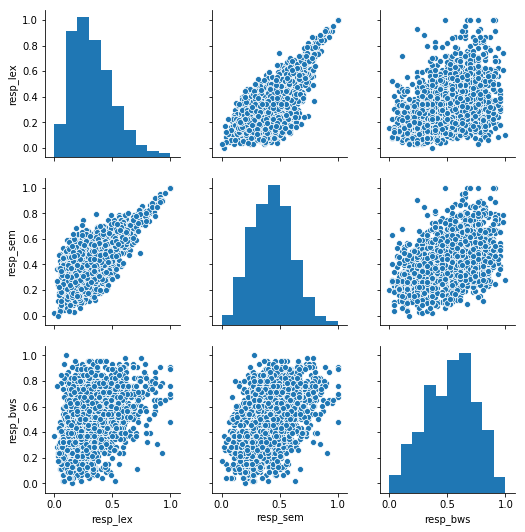

In [13]:
sns.pairplot(pd.DataFrame({"resp_lex":resp_lex, "resp_sem":resp_sem, "resp_bws":resp_bws}))

# ELMo + Attention model

In [14]:
K.clear_session()
sess = tf.Session()

model = build_model_elmo(MAX_SEQ_LEN, attention_layer=True)
initialize_vars(sess)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sent_len (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_sentence (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_mask_LH (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_mask_RH (InputLayer)      [(None, 20)]         0                                            
______________________________________________________________________________________________

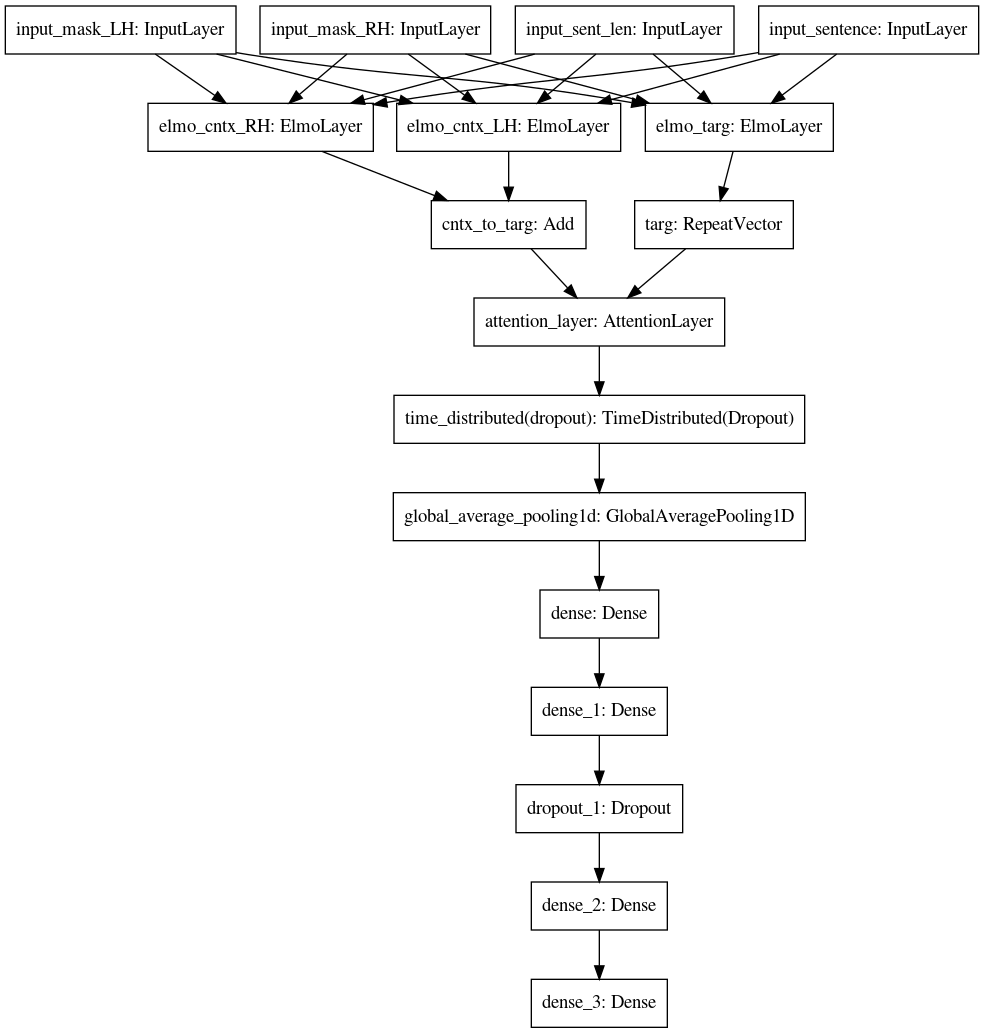

In [15]:
plot_model(model)

# K-fold training and predictions 

In [161]:
_num_iter = 20
_batch_size = 64

## fold: target words

In [22]:
gkf1 = GroupKFold(n_splits=K_FOLDS)

In [163]:
X = sentences
X_notarg = sentences_notarg
y = resp_bws
y_type = 'bws'

### including target word

In [164]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])

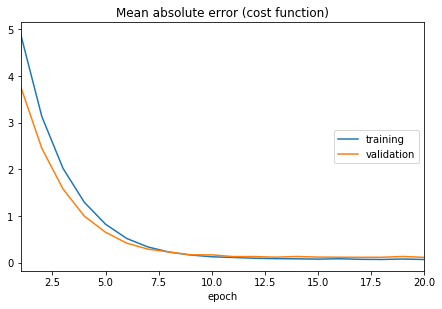

Mean absolute error (cost function):
training   (min:    0.067, max:    4.902, cur:    0.067)
validation (min:    0.113, max:    3.778, cur:    0.113)


In [165]:
train_elmomod_cv(X, y, 
                 gkf_split, False,
                 "./model_weights/model_elmo_wttarg_noattn_"+y_type+"_cvTwrd", 
                 "./model_predict/preds_elmo_wttarg_noattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

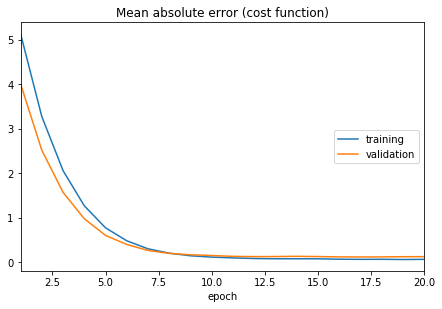

Mean absolute error (cost function):
training   (min:    0.057, max:    5.129, cur:    0.060)
validation (min:    0.114, max:    4.004, cur:    0.121)


In [166]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_elmomod_cv(X, y, 
                 gkf_split, True,
                 "./model_weights/model_elmo_wttarg_wtattn_"+y_type+"_cvTwrd", 
                 "./model_predict/preds_elmo_wttarg_wtattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

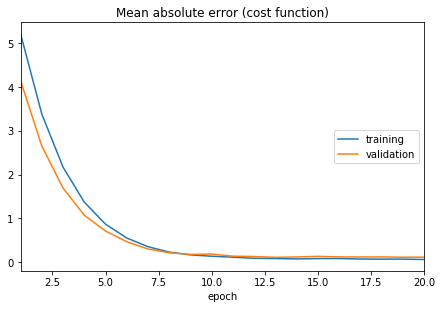

Mean absolute error (cost function):
training   (min:    0.061, max:    5.214, cur:    0.061)
validation (min:    0.111, max:    4.146, cur:    0.116)


In [167]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_elmomod_cv(X_notarg, y,
                 gkf_split, False,
                 "./model_weights/model_elmo_notarg_noattn_"+y_type+"_cvTwrd",  
                 "./model_predict/preds_elmo_notarg_noattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

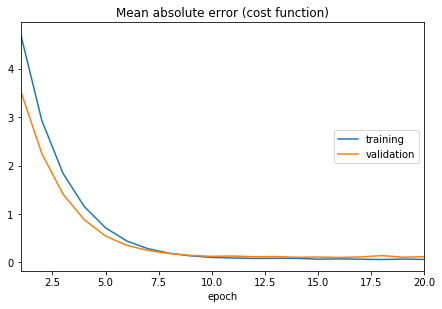

Mean absolute error (cost function):
training   (min:    0.058, max:    4.723, cur:    0.059)
validation (min:    0.100, max:    3.548, cur:    0.116)


In [168]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
train_elmomod_cv(X_notarg, y,
                 gkf_split, True,
                 "./model_weights/model_elmo_notarg_wtattn_"+y_type+"_cvTwrd",  
                 "./model_predict/preds_elmo_notarg_wtattn_"+y_type+"_cvTwrd",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

## fold: target word locations

In [19]:
targ_loc_cat = []
for i in range(df_cloze.shape[0]):
    if(df_cloze['targ_loc_end'][i]): 
        targ_loc_cat.append('last')
    else:
        if(df_cloze['targ_loc_rel'][i] <= 0.5):
            targ_loc_cat.append('less_50')
        elif((df_cloze['targ_loc_rel'][i] > 0.5)&(df_cloze['targ_loc_rel'][i] <= 0.65)):
            targ_loc_cat.append("(50_65]")
        elif((df_cloze['targ_loc_rel'][i] > 0.65)):
            targ_loc_cat.append("more_65")            

In [20]:
Counter(targ_loc_cat)

Counter({'less_50': 402, 'last': 777, 'more_65': 306, '(50_65]': 298})

In [21]:
gkf2 = GroupKFold(n_splits=len(Counter(targ_loc_cat)))

### including target word

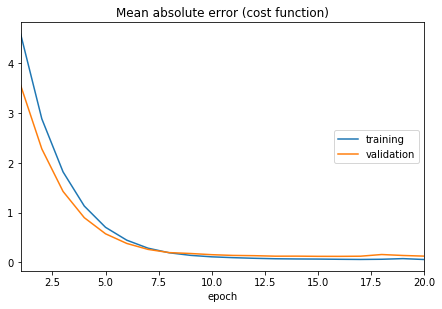

Mean absolute error (cost function):
training   (min:    0.054, max:    4.596, cur:    0.054)
validation (min:    0.118, max:    3.563, cur:    0.122)


In [172]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_elmomod_cv(X, y,
                 gkf_split, False,
                 "./model_weights/model_elmo_wttarg_noattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_elmo_wttarg_noattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

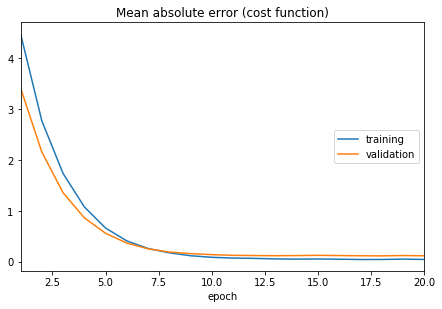

Mean absolute error (cost function):
training   (min:    0.044, max:    4.475, cur:    0.046)
validation (min:    0.116, max:    3.410, cur:    0.117)


In [173]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_elmomod_cv(X, y,
                 gkf_split, True,
                 "./model_weights/model_elmo_wttarg_wtattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_elmo_wttarg_wtattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

### target word as oov token

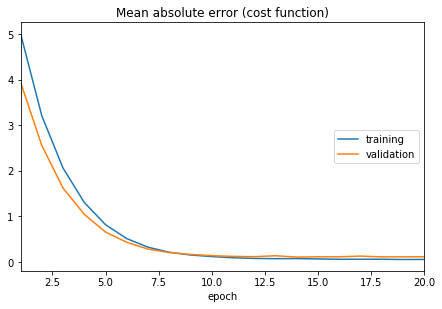

Mean absolute error (cost function):
training   (min:    0.053, max:    5.008, cur:    0.054)
validation (min:    0.106, max:    3.943, cur:    0.113)


In [174]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_elmomod_cv(X_notarg, y, 
                 gkf_split, False,
                 "./model_weights/model_elmo_notarg_noattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_elmo_notarg_noattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

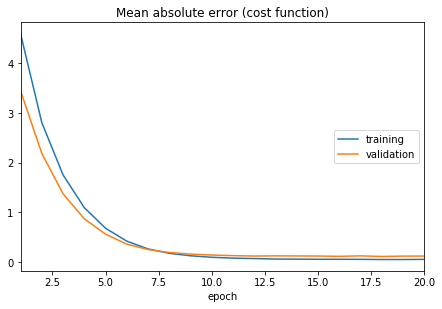

Mean absolute error (cost function):
training   (min:    0.047, max:    4.598, cur:    0.050)
validation (min:    0.109, max:    3.448, cur:    0.117)


In [175]:
gkf_split = gkf2.split(df_cloze['sentence'], groups=targ_loc_cat)
train_elmomod_cv(X_notarg, y,
                 gkf_split, True,
                 "./model_weights/model_elmo_notarg_wtattn_"+y_type+"_cvTloc", 
                 "./model_predict/preds_elmo_notarg_wtattn_"+y_type+"_cvTloc",
                 MAX_SEQ_LEN, _num_iter, _batch_size)

# Classification performance 

In [71]:
def roc_cv(cv_true_scores, pred_score_file_loc, score_type, cut, direction, fig, ax, col):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    pred_score_files = sorted(glob.glob(pred_score_file_loc))

    for i, cv_true_score in enumerate(cv_true_scores):
        if(direction=="high"):
            fpr, tpr, _ = roc_curve(cv_true_score > np.quantile(cv_true_score, q=[cut]), np.load(pred_score_files[i]))
        if(direction=="low"):
            fpr, tpr, _ = roc_curve(cv_true_score < np.quantile(cv_true_score, q=[cut]), 1-np.load(pred_score_files[i]))
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        # sns.lineplot(fpr, tpr)
        ax.plot(fpr, tpr, 
                color=col, alpha=0.1,
                # label = 'ROC fold %d (AUC=%0.2f, n=%d)' % (i, roc_auc, fold_set.shape[0])
               )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)    
    ax.plot(mean_fpr, mean_tpr, 
             color=col, alpha=1,
             label=r'Mean ROC:'+score_type+' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, 1.96*std_auc),
             lw=2)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC__'+str(cut)+"_"+str(direction)+'_5-fold')
    # ax.legend(loc=4, bbox_to_anchor=(0.5, -0.2))
    ax.legend()

In [23]:
sent_test_cvTwrd = []
sent_test_cvTloc = []
resp_bws_cvTwrd = []
resp_bws_cvTloc = []
resp_lex_cvTwrd = []
resp_lex_cvTloc = []
resp_sem_cvTwrd = []
resp_sem_cvTloc = []


for train_idx, test_idx in gkf1.split(df_cloze['sentence'], groups=df_cloze['targ']):
    sent_test_cvTwrd.append([sent[test_idx] for sent in sentences])
    resp_bws_cvTwrd.append([resp_bws[i] for i in test_idx])
    resp_sem_cvTwrd.append([resp_sem[i] for i in test_idx])
    resp_lex_cvTwrd.append([resp_lex[i] for i in test_idx])
    
for train_idx, test_idx in gkf2.split(df_cloze['sentence'], groups=targ_loc_cat):
    sent_test_cvTloc.append([sent[test_idx] for sent in sentences])
    resp_bws_cvTloc.append([resp_bws[i] for i in test_idx])
    resp_sem_cvTloc.append([resp_sem[i] for i in test_idx])
    resp_lex_cvTloc.append([resp_lex[i] for i in test_idx])

## CV over target words vs. target word location

In [170]:
Counter(targ_loc_cat)

Counter({'less_50': 402, 'last': 777, 'more_65': 306, '(50_65]': 298})

### fitted to: BWS score
- target location may bias the prediction results in some cases, but not by much
- attention layer does not improve the performance
- including a target word does not help 

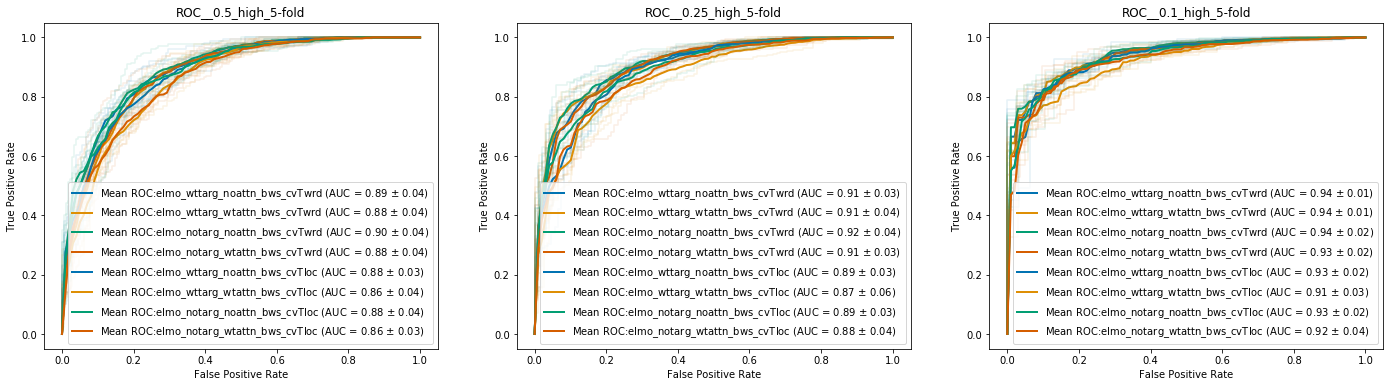

In [177]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTwrd*", "elmo_wttarg_noattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[0])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTwrd*", "elmo_wttarg_wtattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[1])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_bws_cvTwrd*", "elmo_notarg_noattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[2])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTwrd*", "elmo_notarg_wtattn_bws_cvTwrd", 0.50, "high", fig, axes[0], tt_col[3])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTloc*", "elmo_wttarg_noattn_bws_cvTloc", 0.50, "high", fig, axes[0], tt_col[0])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTloc*", "elmo_wttarg_wtattn_bws_cvTloc", 0.50, "high", fig, axes[0], tt_col[1])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_noattn_bws_cvTloc*", "elmo_notarg_noattn_bws_cvTloc", 0.50, "high", fig, axes[0], tt_col[2])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTloc*", "elmo_notarg_wtattn_bws_cvTloc", 0.50, "high", fig, axes[0], tt_col[3])

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTwrd*", "elmo_wttarg_noattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[0])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTwrd*", "elmo_wttarg_wtattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[1])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_bws_cvTwrd*", "elmo_notarg_noattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[2])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTwrd*", "elmo_notarg_wtattn_bws_cvTwrd", 0.25, "high", fig, axes[1], tt_col[3])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTloc*", "elmo_wttarg_noattn_bws_cvTloc", 0.25, "high", fig, axes[1], tt_col[0])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTloc*", "elmo_wttarg_wtattn_bws_cvTloc", 0.25, "high", fig, axes[1], tt_col[1])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_noattn_bws_cvTloc*", "elmo_notarg_noattn_bws_cvTloc", 0.25, "high", fig, axes[1], tt_col[2])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTloc*", "elmo_notarg_wtattn_bws_cvTloc", 0.25, "high", fig, axes[1], tt_col[3])

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTwrd*", "elmo_wttarg_noattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[0])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTwrd*", "elmo_wttarg_wtattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[1])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_bws_cvTwrd*", "elmo_notarg_noattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[2])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTwrd*", "elmo_notarg_wtattn_bws_cvTwrd", 0.10, "high", fig, axes[2], tt_col[3])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTloc*", "elmo_wttarg_noattn_bws_cvTloc", 0.10, "high", fig, axes[2], tt_col[0])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTloc*", "elmo_wttarg_wtattn_bws_cvTloc", 0.10, "high", fig, axes[2], tt_col[1])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_noattn_bws_cvTloc*", "elmo_notarg_noattn_bws_cvTloc", 0.10, "high", fig, axes[2], tt_col[2])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTloc*", "elmo_notarg_wtattn_bws_cvTloc", 0.10, "high", fig, axes[2], tt_col[3])


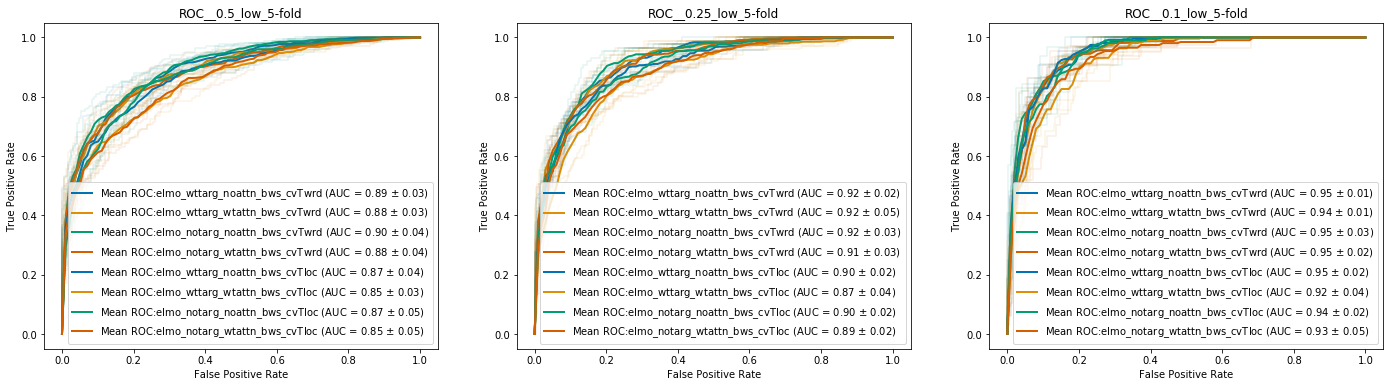

In [176]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTwrd*", "elmo_wttarg_noattn_bws_cvTwrd", 0.50, "low", fig, axes[0], tt_col[0])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTwrd*", "elmo_wttarg_wtattn_bws_cvTwrd", 0.50, "low", fig, axes[0], tt_col[1])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_bws_cvTwrd*", "elmo_notarg_noattn_bws_cvTwrd", 0.50, "low", fig, axes[0], tt_col[2])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTwrd*", "elmo_notarg_wtattn_bws_cvTwrd", 0.50, "low", fig, axes[0], tt_col[3])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTloc*", "elmo_wttarg_noattn_bws_cvTloc", 0.50, "low", fig, axes[0], tt_col[0])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTloc*", "elmo_wttarg_wtattn_bws_cvTloc", 0.50, "low", fig, axes[0], tt_col[1])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_noattn_bws_cvTloc*", "elmo_notarg_noattn_bws_cvTloc", 0.50, "low", fig, axes[0], tt_col[2])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTloc*", "elmo_notarg_wtattn_bws_cvTloc", 0.50, "low", fig, axes[0], tt_col[3])

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTwrd*", "elmo_wttarg_noattn_bws_cvTwrd", 0.25, "low", fig, axes[1], tt_col[0])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTwrd*", "elmo_wttarg_wtattn_bws_cvTwrd", 0.25, "low", fig, axes[1], tt_col[1])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_bws_cvTwrd*", "elmo_notarg_noattn_bws_cvTwrd", 0.25, "low", fig, axes[1], tt_col[2])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTwrd*", "elmo_notarg_wtattn_bws_cvTwrd", 0.25, "low", fig, axes[1], tt_col[3])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTloc*", "elmo_wttarg_noattn_bws_cvTloc", 0.25, "low", fig, axes[1], tt_col[0])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTloc*", "elmo_wttarg_wtattn_bws_cvTloc", 0.25, "low", fig, axes[1], tt_col[1])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_noattn_bws_cvTloc*", "elmo_notarg_noattn_bws_cvTloc", 0.25, "low", fig, axes[1], tt_col[2])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTloc*", "elmo_notarg_wtattn_bws_cvTloc", 0.25, "low", fig, axes[1], tt_col[3])

roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTwrd*", "elmo_wttarg_noattn_bws_cvTwrd", 0.10, "low", fig, axes[2], tt_col[0])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTwrd*", "elmo_wttarg_wtattn_bws_cvTwrd", 0.10, "low", fig, axes[2], tt_col[1])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_bws_cvTwrd*", "elmo_notarg_noattn_bws_cvTwrd", 0.10, "low", fig, axes[2], tt_col[2])
roc_cv(resp_bws_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTwrd*", "elmo_notarg_wtattn_bws_cvTwrd", 0.10, "low", fig, axes[2], tt_col[3])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_bws_cvTloc*", "elmo_wttarg_noattn_bws_cvTloc", 0.10, "low", fig, axes[2], tt_col[0])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_bws_cvTloc*", "elmo_wttarg_wtattn_bws_cvTloc", 0.10, "low", fig, axes[2], tt_col[1])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_noattn_bws_cvTloc*", "elmo_notarg_noattn_bws_cvTloc", 0.10, "low", fig, axes[2], tt_col[2])
roc_cv(resp_bws_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_bws_cvTloc*", "elmo_notarg_wtattn_bws_cvTloc", 0.10, "low", fig, axes[2], tt_col[3])


### fitted to: Semantic distance
- target location may bias the prediction results in some cases, but not by much
- attention layer maybe helpful in some cases
- including a target word does not help 

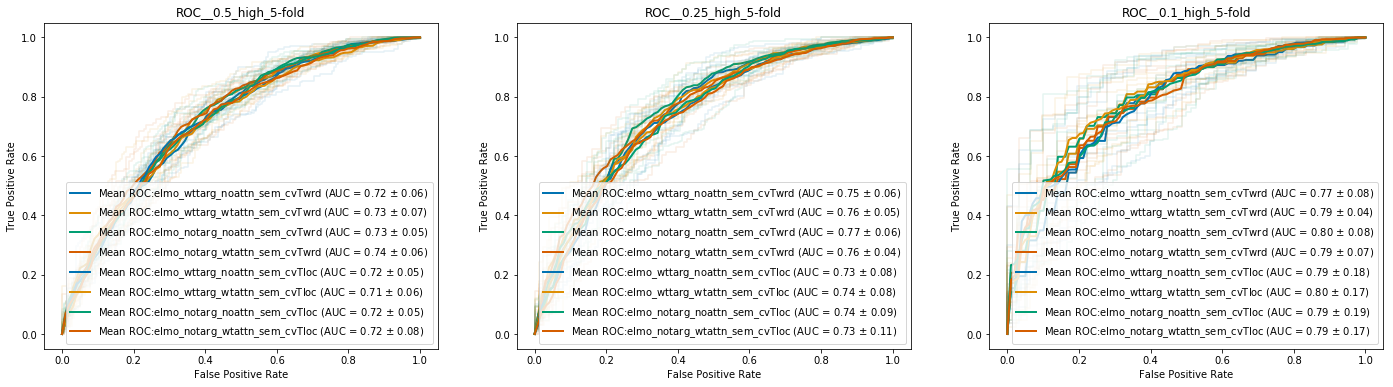

In [75]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTwrd*", "elmo_wttarg_noattn_sem_cvTwrd", 0.50, "high", fig, axes[0], tt_col[0])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTwrd*", "elmo_wttarg_wtattn_sem_cvTwrd", 0.50, "high", fig, axes[0], tt_col[1])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_sem_cvTwrd*", "elmo_notarg_noattn_sem_cvTwrd", 0.50, "high", fig, axes[0], tt_col[2])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTwrd*", "elmo_notarg_wtattn_sem_cvTwrd", 0.50, "high", fig, axes[0], tt_col[3])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTloc*", "elmo_wttarg_noattn_sem_cvTloc", 0.50, "high", fig, axes[0], tt_col[0])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTloc*", "elmo_wttarg_wtattn_sem_cvTloc", 0.50, "high", fig, axes[0], tt_col[1])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_noattn_sem_cvTloc*", "elmo_notarg_noattn_sem_cvTloc", 0.50, "high", fig, axes[0], tt_col[2])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTloc*", "elmo_notarg_wtattn_sem_cvTloc", 0.50, "high", fig, axes[0], tt_col[3])

roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTwrd*", "elmo_wttarg_noattn_sem_cvTwrd", 0.25, "high", fig, axes[1], tt_col[0])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTwrd*", "elmo_wttarg_wtattn_sem_cvTwrd", 0.25, "high", fig, axes[1], tt_col[1])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_sem_cvTwrd*", "elmo_notarg_noattn_sem_cvTwrd", 0.25, "high", fig, axes[1], tt_col[2])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTwrd*", "elmo_notarg_wtattn_sem_cvTwrd", 0.25, "high", fig, axes[1], tt_col[3])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTloc*", "elmo_wttarg_noattn_sem_cvTloc", 0.25, "high", fig, axes[1], tt_col[0])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTloc*", "elmo_wttarg_wtattn_sem_cvTloc", 0.25, "high", fig, axes[1], tt_col[1])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_noattn_sem_cvTloc*", "elmo_notarg_noattn_sem_cvTloc", 0.25, "high", fig, axes[1], tt_col[2])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTloc*", "elmo_notarg_wtattn_sem_cvTloc", 0.25, "high", fig, axes[1], tt_col[3])

roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTwrd*", "elmo_wttarg_noattn_sem_cvTwrd", 0.10, "high", fig, axes[2], tt_col[0])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTwrd*", "elmo_wttarg_wtattn_sem_cvTwrd", 0.10, "high", fig, axes[2], tt_col[1])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_sem_cvTwrd*", "elmo_notarg_noattn_sem_cvTwrd", 0.10, "high", fig, axes[2], tt_col[2])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTwrd*", "elmo_notarg_wtattn_sem_cvTwrd", 0.10, "high", fig, axes[2], tt_col[3])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTloc*", "elmo_wttarg_noattn_sem_cvTloc", 0.10, "high", fig, axes[2], tt_col[0])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTloc*", "elmo_wttarg_wtattn_sem_cvTloc", 0.10, "high", fig, axes[2], tt_col[1])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_noattn_sem_cvTloc*", "elmo_notarg_noattn_sem_cvTloc", 0.10, "high", fig, axes[2], tt_col[2])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTloc*", "elmo_notarg_wtattn_sem_cvTloc", 0.10, "high", fig, axes[2], tt_col[3])


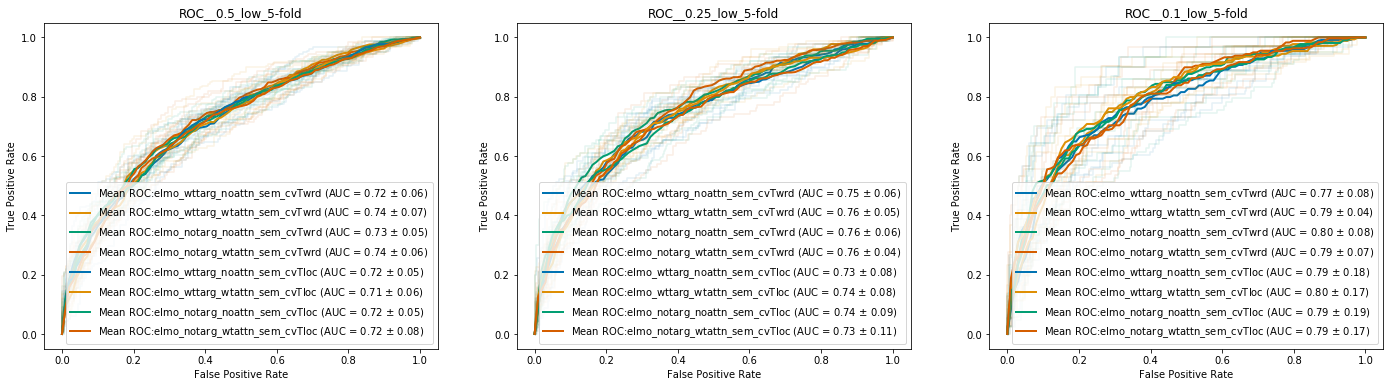

In [76]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTwrd*", "elmo_wttarg_noattn_sem_cvTwrd", 0.50, "low", fig, axes[0], tt_col[0])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTwrd*", "elmo_wttarg_wtattn_sem_cvTwrd", 0.50, "low", fig, axes[0], tt_col[1])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_sem_cvTwrd*", "elmo_notarg_noattn_sem_cvTwrd", 0.50, "low", fig, axes[0], tt_col[2])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTwrd*", "elmo_notarg_wtattn_sem_cvTwrd", 0.50, "low", fig, axes[0], tt_col[3])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTloc*", "elmo_wttarg_noattn_sem_cvTloc", 0.50, "low", fig, axes[0], tt_col[0])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTloc*", "elmo_wttarg_wtattn_sem_cvTloc", 0.50, "low", fig, axes[0], tt_col[1])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_noattn_sem_cvTloc*", "elmo_notarg_noattn_sem_cvTloc", 0.50, "low", fig, axes[0], tt_col[2])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTloc*", "elmo_notarg_wtattn_sem_cvTloc", 0.50, "low", fig, axes[0], tt_col[3])

roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTwrd*", "elmo_wttarg_noattn_sem_cvTwrd", 0.25, "low", fig, axes[1], tt_col[0])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTwrd*", "elmo_wttarg_wtattn_sem_cvTwrd", 0.25, "low", fig, axes[1], tt_col[1])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_sem_cvTwrd*", "elmo_notarg_noattn_sem_cvTwrd", 0.25, "low", fig, axes[1], tt_col[2])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTwrd*", "elmo_notarg_wtattn_sem_cvTwrd", 0.25, "low", fig, axes[1], tt_col[3])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTloc*", "elmo_wttarg_noattn_sem_cvTloc", 0.25, "low", fig, axes[1], tt_col[0])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTloc*", "elmo_wttarg_wtattn_sem_cvTloc", 0.25, "low", fig, axes[1], tt_col[1])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_noattn_sem_cvTloc*", "elmo_notarg_noattn_sem_cvTloc", 0.25, "low", fig, axes[1], tt_col[2])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTloc*", "elmo_notarg_wtattn_sem_cvTloc", 0.25, "low", fig, axes[1], tt_col[3])

roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTwrd*", "elmo_wttarg_noattn_sem_cvTwrd", 0.10, "low", fig, axes[2], tt_col[0])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTwrd*", "elmo_wttarg_wtattn_sem_cvTwrd", 0.10, "low", fig, axes[2], tt_col[1])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_noattn_sem_cvTwrd*", "elmo_notarg_noattn_sem_cvTwrd", 0.10, "low", fig, axes[2], tt_col[2])
roc_cv(resp_sem_cvTwrd, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTwrd*", "elmo_notarg_wtattn_sem_cvTwrd", 0.10, "low", fig, axes[2], tt_col[3])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_noattn_sem_cvTloc*", "elmo_wttarg_noattn_sem_cvTloc", 0.10, "low", fig, axes[2], tt_col[0])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_wttarg_wtattn_sem_cvTloc*", "elmo_wttarg_wtattn_sem_cvTloc", 0.10, "low", fig, axes[2], tt_col[1])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_noattn_sem_cvTloc*", "elmo_notarg_noattn_sem_cvTloc", 0.10, "low", fig, axes[2], tt_col[2])
roc_cv(resp_sem_cvTloc, "./model_predict/preds_elmo_notarg_wtattn_sem_cvTloc*", "elmo_notarg_wtattn_sem_cvTloc", 0.10, "low", fig, axes[2], tt_col[3])


# Prediction results 

In [15]:
K.clear_session()
sess = tf.Session()

model_notarg = build_model_elmo(MAX_SEQ_LEN, True)
model_wttarg = build_model_elmo(MAX_SEQ_LEN, True)
initialize_vars(sess)

model_notarg.load_weights("model_weights/model_elmo_notarg_wtattn_sem_cvTwrd0.h5")
model_wttarg.load_weights("model_weights/model_elmo_wttarg_wtattn_sem_cvTwrd0.h5")

## score predictions 

In [24]:
# attn_bws_pred_test = np.reshape(model.predict(sent_test_cvTwrd[0], batch_size=128), -1)
notarg_wtattn_pred_test = np.reshape(model_notarg.predict(sent_test_cvTwrd[0], batch_size=128), -1)
wttarg_wtattn_pred_test = np.reshape(model_wttarg.predict(sent_test_cvTwrd[0], batch_size=128), -1)

### for fold 0

SpearmanrResult(correlation=0.35972915972915975, pvalue=3.666024143021618e-12)
0.1619806818120254


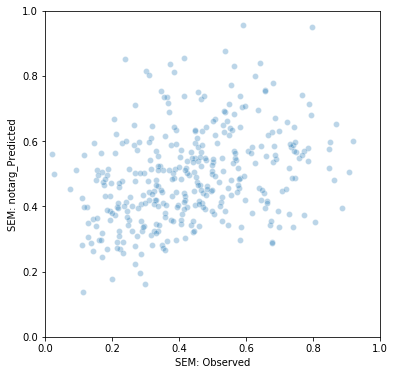

In [79]:
plt.figure(figsize=(6,6))
sns.scatterplot(resp_sem_cvTwrd[0], notarg_wtattn_pred_test, alpha=0.3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("SEM: Observed")
plt.ylabel("SEM: notarg_Predicted")
print(spearmanr(resp_sem_cvTwrd[0], notarg_wtattn_pred_test))
print(mean_absolute_error(resp_sem_cvTwrd[0], notarg_wtattn_pred_test))

SpearmanrResult(correlation=0.46329198579198577, pvalue=4.4616889582313914e-20)
0.13847326193902756


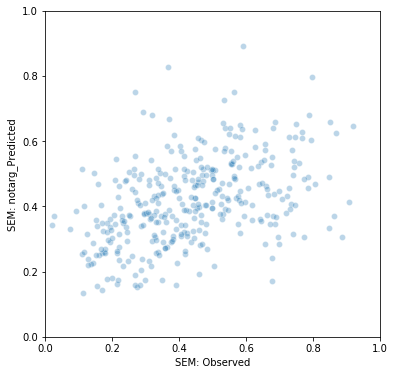

In [80]:
plt.figure(figsize=(6,6))
sns.scatterplot(resp_sem_cvTwrd[0], wttarg_wtattn_pred_test, alpha=0.3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("SEM: Observed")
plt.ylabel("SEM: notarg_Predicted")
print(spearmanr(resp_sem_cvTwrd[0], wttarg_wtattn_pred_test))
print(mean_absolute_error(resp_sem_cvTwrd[0], wttarg_wtattn_pred_test))

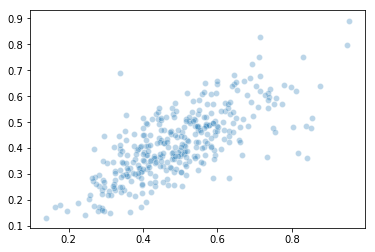

In [27]:
sns.scatterplot(notarg_wtattn_pred_test, wttarg_wtattn_pred_test, alpha=0.3)

### consolidating predictions from all cv folds

SpearmanrResult(correlation=0.3978354151491442, pvalue=1.0978808548658384e-68)
0.13790001076714384


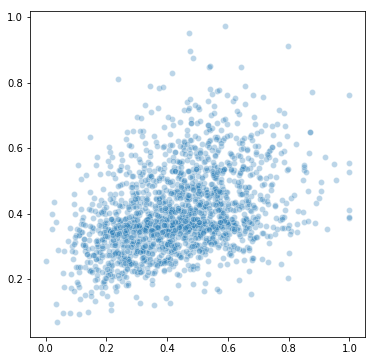

In [160]:
tt_files = sorted(glob.glob("./model_predict/preds_elmo_notarg_wtattn_sem_cvTwrd*"))
tt_preds = [np.load(f) for f in tt_files]
tt_preds = [x for xx in tt_preds for x in xx]
tt_obs = sum(resp_sem_cvTwrd, [])

plt.figure(figsize=(6,6))
sns.scatterplot(tt_obs, tt_preds, alpha=0.3)
print(spearmanr(tt_obs, tt_preds))
print(mean_absolute_error(tt_obs, tt_preds))

SpearmanrResult(correlation=0.441008948985516, pvalue=9.722925686757293e-86)
0.13552408135215224


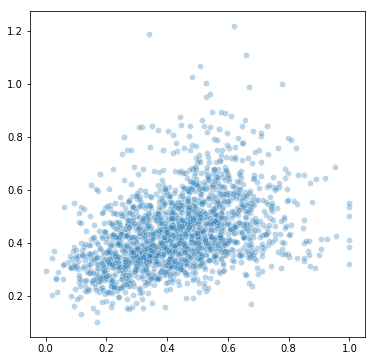

In [159]:
tt_files = sorted(glob.glob("./model_predict/preds_elmo_wttarg_wtattn_sem_cvTwrd*"))
tt_preds = [np.load(f) for f in tt_files]
tt_preds = [x for xx in tt_preds for x in xx]
tt_obs = sum(resp_sem_cvTwrd, [])

plt.figure(figsize=(6,6))
sns.scatterplot(tt_obs, tt_preds, alpha=0.3)
print(spearmanr(tt_obs, tt_preds))
print(mean_absolute_error(tt_obs, tt_preds))

## attention interpretations

In [138]:
model_notarg_sfmxres = Model(model_notarg.inputs, model_notarg.get_layer('attention_layer').output[1])
model_wttarg_sfmxres = Model(model_wttarg.inputs, model_wttarg.get_layer('attention_layer').output[1])
# initialize_vars(sess)

In [139]:
hi_test_idx15 = np.prod([(resp_bws_cvTwrd[0] > np.quantile(resp_bws_cvTwrd[0], q=[0.90])),
                         (resp_sem_cvTwrd[0] > np.quantile(resp_sem_cvTwrd[0], q=[0.90]))], axis=0)
lo_test_idx15 = np.prod([(resp_bws_cvTwrd[0] < np.quantile(resp_bws_cvTwrd[0], q=[0.13])),
                         (resp_sem_cvTwrd[0] < np.quantile(resp_sem_cvTwrd[0], q=[0.13]))], axis=0)
hi_test_idx15 = np.where(hi_test_idx15)[0]
lo_test_idx15 = np.where(lo_test_idx15)[0]
(hi_test_idx15, lo_test_idx15)

(array([ 10,  11,  18,  37,  49, 172, 186, 217, 234, 295]),
 array([  5,  38,  39,  82, 155, 216, 222, 299, 301, 348, 349]))

In [140]:
tt_notarg_attn = model_notarg_sfmxres.predict([sent for sent in sent_test_cvTwrd[0]])[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict([sent for sent in sent_test_cvTwrd[0]])[:,0,:]

#### high informative sentences

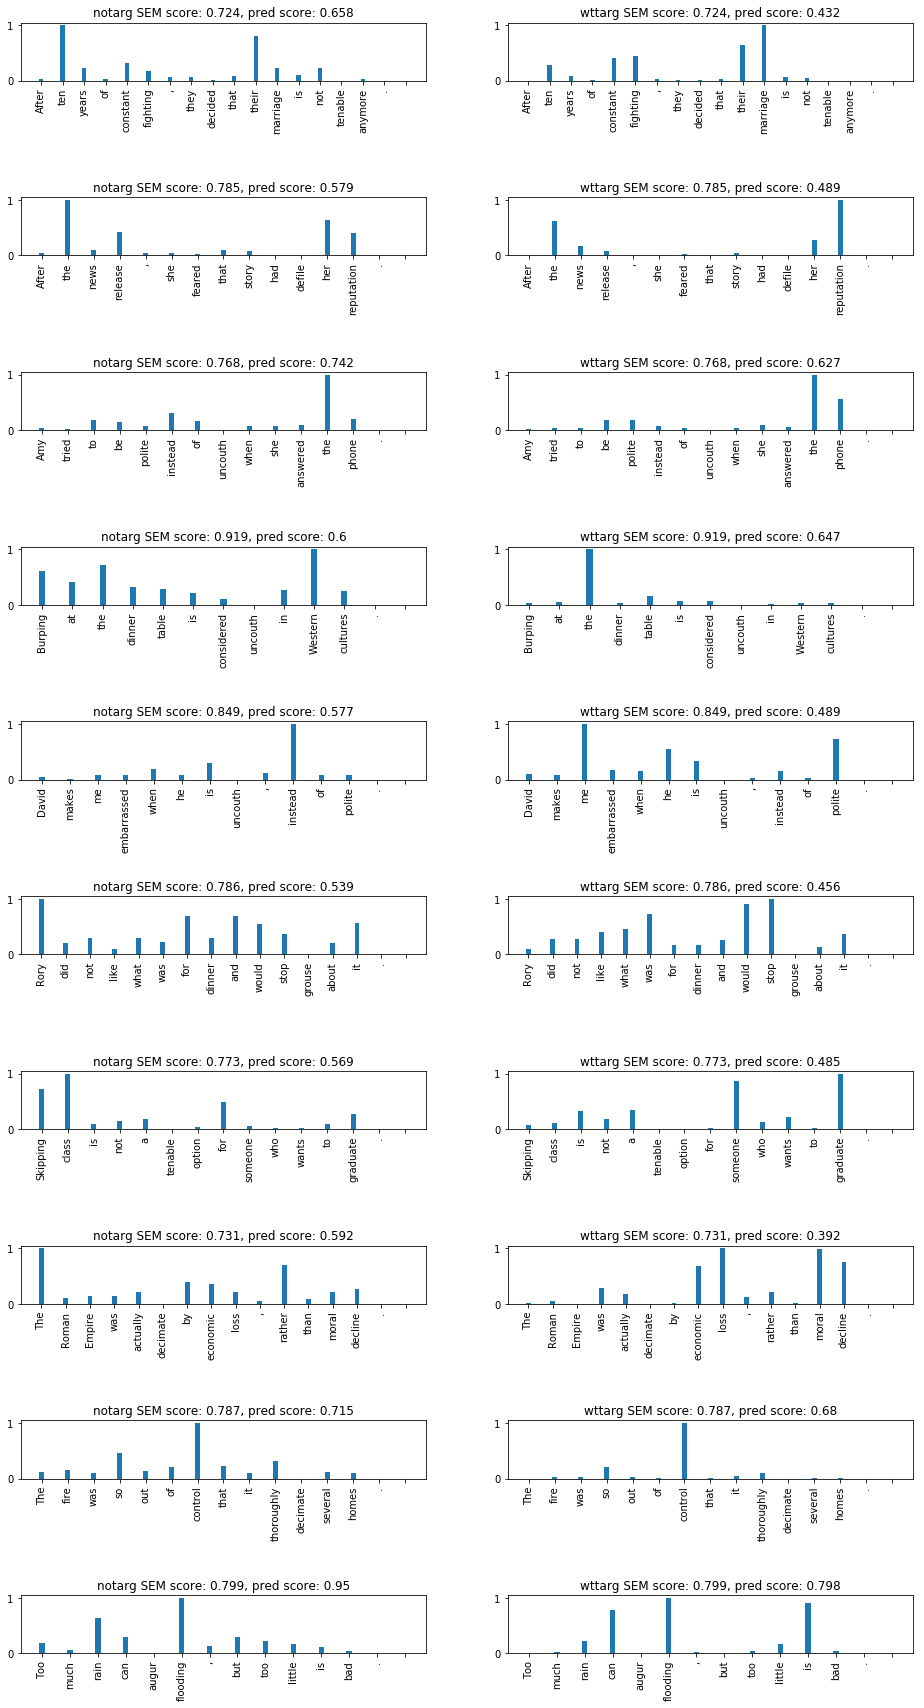

In [141]:
fig, axes = plt.subplots(len(hi_test_idx15), 2, figsize=(16, len(hi_test_idx15)*3))
fig.subplots_adjust(hspace=2)

for i,j in enumerate(hi_test_idx15):
    tt1 = tt_notarg_attn[j]*(sent_test_cvTwrd[0][2][j]+sent_test_cvTwrd[0][3][j])
    tt1 = (tt1-tt1.min())/(tt1.max()-tt1.min())    
    tt2 = tt_wttarg_attn[j]*(sent_test_cvTwrd[0][2][j]+sent_test_cvTwrd[0][3][j])
    tt2 = (tt2-tt2.min())/(tt2.max()-tt2.min())    
    axes[i][0].bar(x=sent_test_cvTwrd[0][1][j], height=tt1, width=0.2)
    axes[i][0].set_title("notarg "+"SEM score: "+str(round(resp_sem_cvTwrd[0][j], 3))+
                      ", pred score: "+str(round(notarg_wtattn_pred_test[j], 3)))
    axes[i][1].bar(x=sent_test_cvTwrd[0][1][j], height=tt2, width=0.2)
    axes[i][1].set_title("wttarg "+"SEM score: "+str(round(resp_sem_cvTwrd[0][j], 3))+
                      ", pred score: "+str(round(wttarg_wtattn_pred_test[j], 3)))    
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)

#### low informative sentences

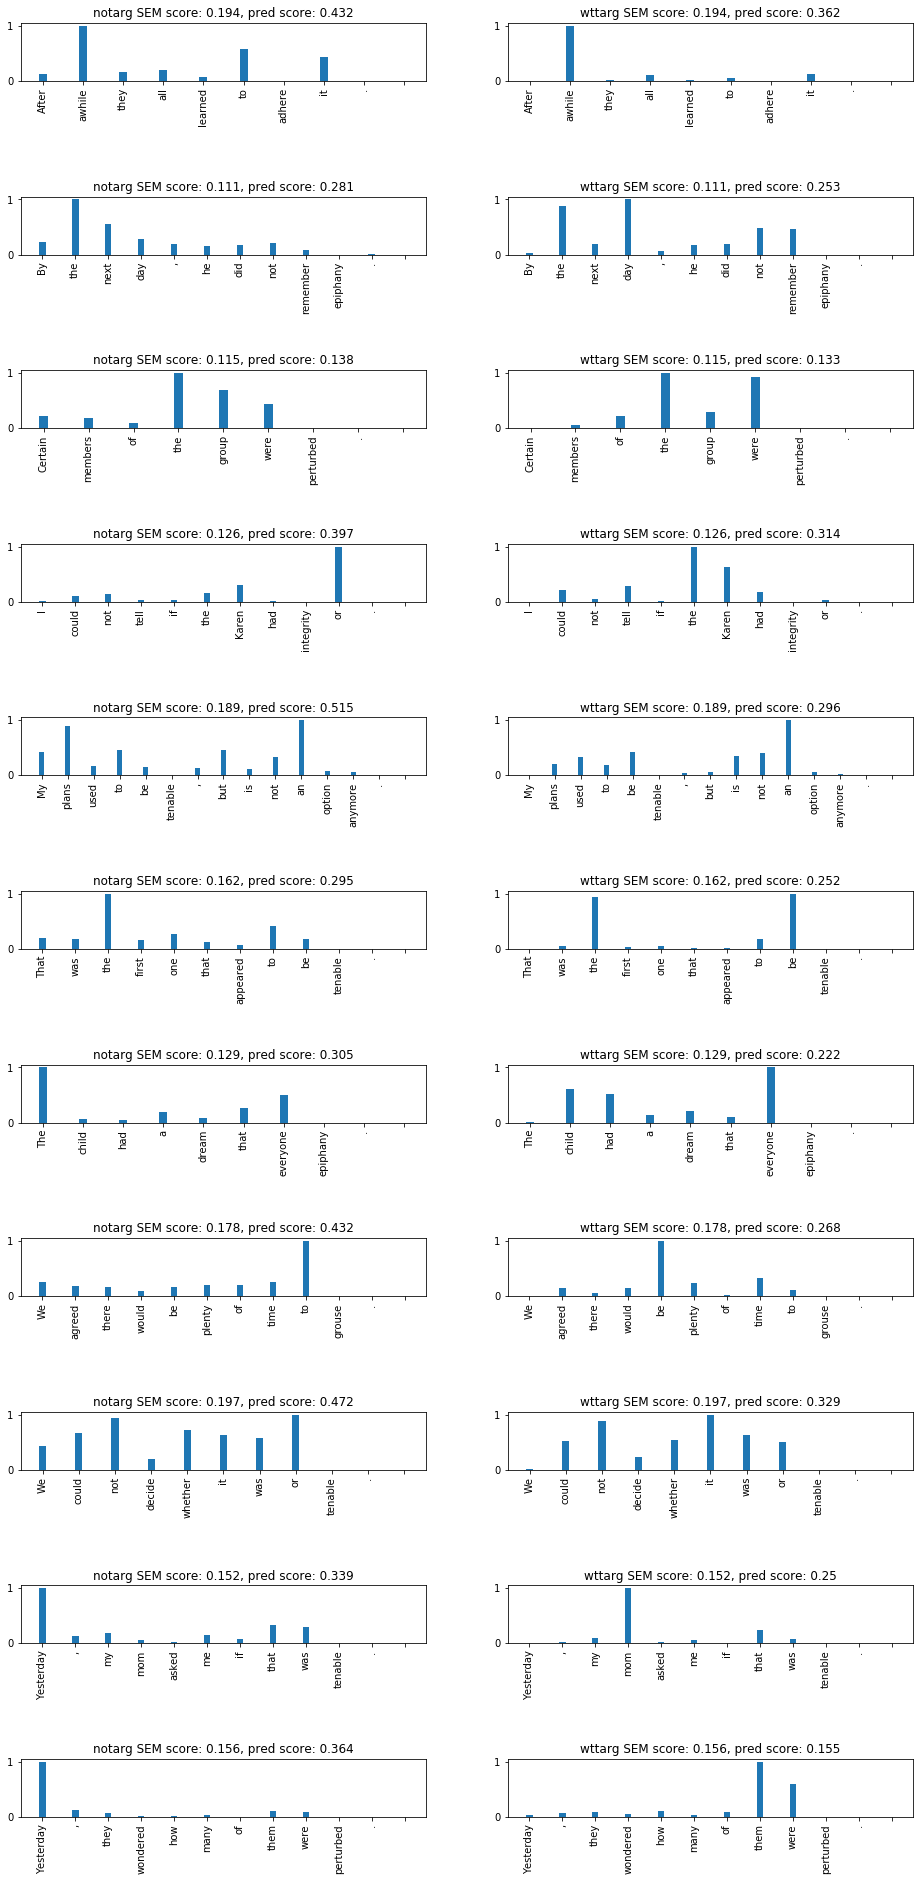

In [85]:
fig, axes = plt.subplots(len(lo_test_idx15), 2, figsize=(16, len(lo_test_idx15)*3))
fig.subplots_adjust(hspace=2)

for i,j in enumerate(lo_test_idx15):
    tt1 = tt_notarg_attn[j]*(sent_test_cvTwrd[0][2][j]+sent_test_cvTwrd[0][3][j])
    tt1 = (tt1-tt1.min())/(tt1.max()-tt1.min())    
    tt2 = tt_wttarg_attn[j]*(sent_test_cvTwrd[0][2][j]+sent_test_cvTwrd[0][3][j])
    tt2 = (tt2-tt2.min())/(tt2.max()-tt2.min())    
    
    axes[i][0].bar(x=sent_test_cvTwrd[0][1][j], height=tt1, width=0.2)
    axes[i][0].set_title("notarg "+"SEM score: "+str(round(resp_sem_cvTwrd[0][j], 3))+
                      ", pred score: "+str(round(notarg_wtattn_pred_test[j], 3)))
    axes[i][1].bar(x=sent_test_cvTwrd[0][1][j], height=tt2, width=0.2)
    axes[i][1].set_title("wttarg "+"SEM score: "+str(round(resp_sem_cvTwrd[0][j], 3))+
                      ", pred score: "+str(round(wttarg_wtattn_pred_test[j], 3)))    
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)

# Anecdotal examples - High informative sentences
- context cue categories (based on DSCoVAR_TR2016-005_AnnotatingContextCues.docx)
    - Synonymous
    - Antonymous
    - Causal

In [86]:
df_ex_hinfo = pd.read_csv("./dataset/hiinfo_examples.csv")
df_ex_hinfo

,Cue,Cue Words,Example context,targ
0,Synonym,"X, that is, Y...","The world is full of zetetics, that is, skeptics.",zetetics
1,Synonym,"X , or Y....",The world is full of zetetics or skeptics.,zetetics
2,Synonym,"X, i.e., Y....","The world is full of zetetics, i.e., skeptics.",zetetics
3,Synonym,"X, in other words, Y","The world is full of zetetics , in other words, skeptics.",zetetics
4,Synonym,"X, meaning (that) Y",John is a zetetics which means that he is skeptical.,zetetics
5,Antonym,"X, unlike, Y...","These are sapid, unlike the yummy ones we had yesterday.",sapid
6,Antonym,"X , instead of Y....",These are sapid instead of yummy.,sapid
7,Antonym,"not X, but Y....","These are not sapid, but yummy.",sapid
8,Antonym,"X, rather than Y...","These are sapid, rather than yummy.",sapid
9,Antonym,"X, as opposed to Y...","These are sapid, as opposed to yummy",sapid


In [87]:
sentences_high = proc_sentences(df_ex_hinfo, "Example context", "targ")

In [88]:
sentences_high_syn = [xx[df_ex_hinfo["Cue "]=="Synonym"] for xx in sentences_high]
sentences_high_ant = [xx[df_ex_hinfo["Cue "]=="Antonym"] for xx in sentences_high]
sentences_high_cau = [xx[df_ex_hinfo["Cue "]=="Causal"]  for xx in sentences_high]

## synonym

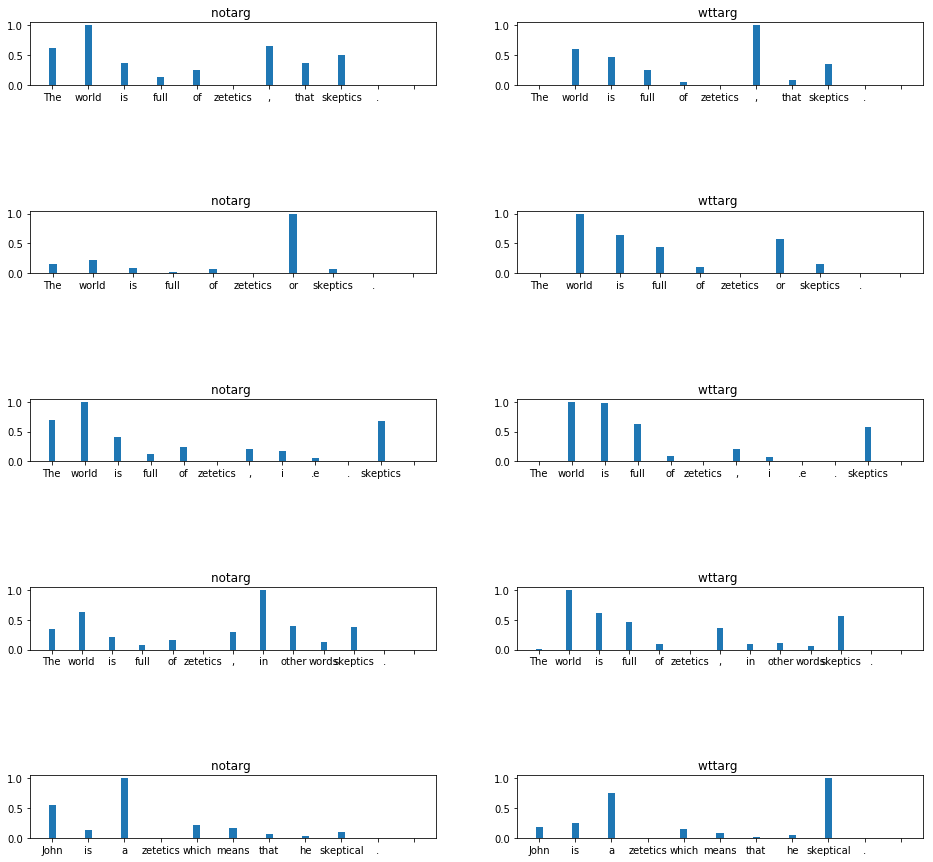

In [89]:
sent_test = sentences_high_syn
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = tt_notarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt2 = tt_wttarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt1 = (tt1-tt1.min())/(tt1.max()-tt1.min())    
    tt2 = (tt2-tt2.min())/(tt2.max()-tt2.min())    
    
    axes[i][0].bar(x=sent_test[1][i], height=tt1, width=0.2)
    axes[i][1].bar(x=sent_test[1][i], height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")    

## antonym

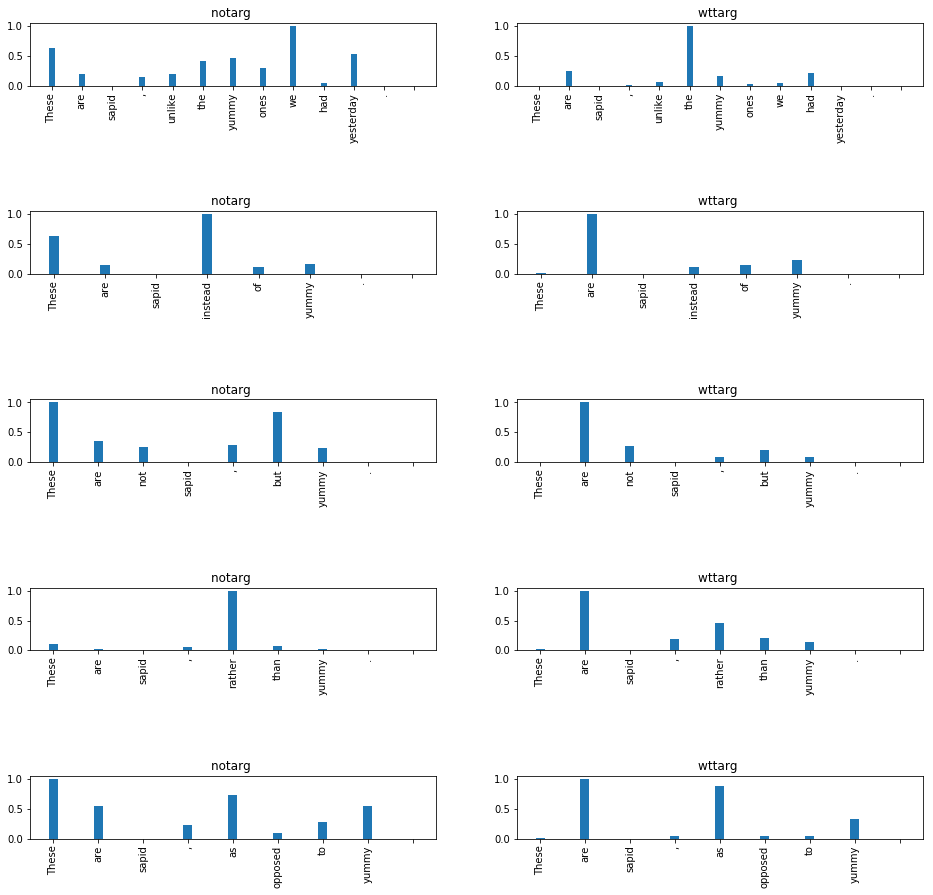

In [90]:
sent_test = sentences_high_ant
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = tt_notarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt2 = tt_wttarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt1 = (tt1-tt1.min())/(tt1.max()-tt1.min())    
    tt2 = (tt2-tt2.min())/(tt2.max()-tt2.min())    
    
    axes[i][0].bar(x=sent_test[1][i], height=tt1, width=0.2)
    axes[i][1].bar(x=sent_test[1][i], height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")    
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)    

## causal

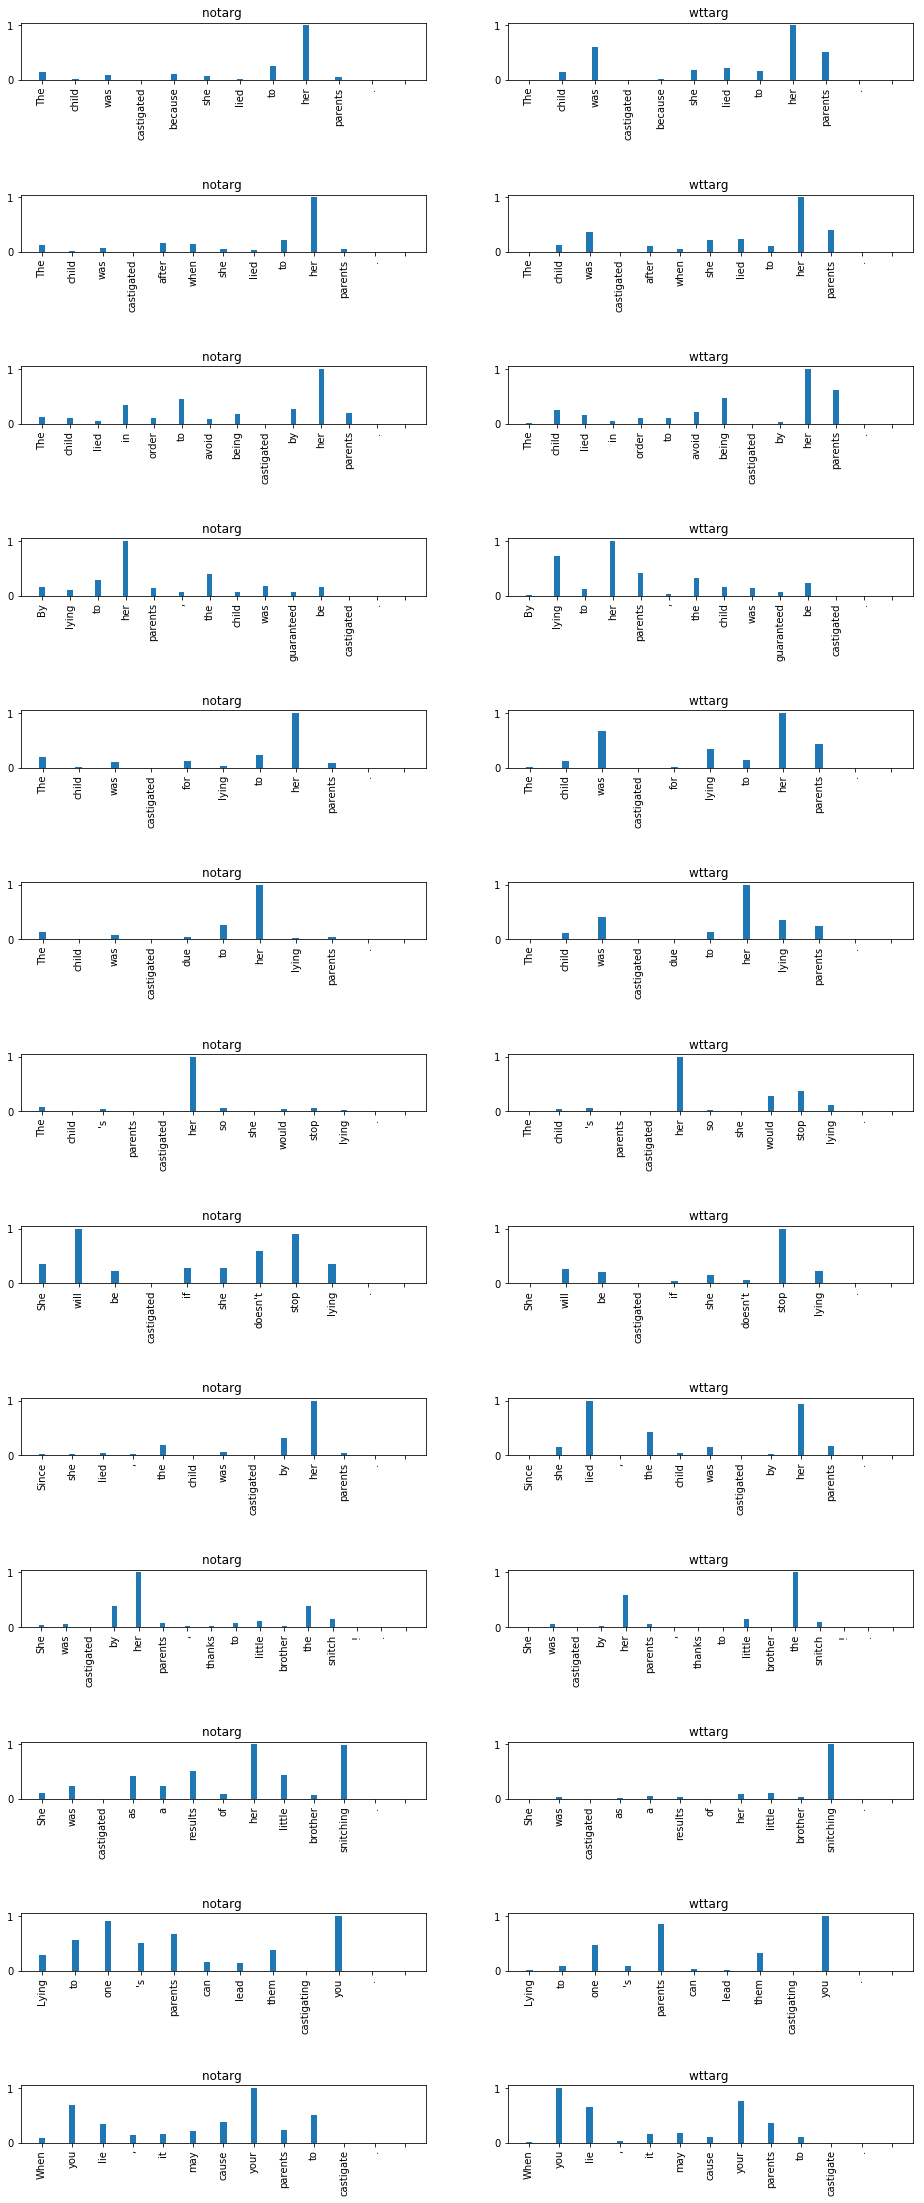

In [91]:
sent_test = sentences_high_cau
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = tt_notarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt2 = tt_wttarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt1 = (tt1-tt1.min())/(tt1.max()-tt1.min())    
    tt2 = (tt2-tt2.min())/(tt2.max()-tt2.min())    
    
    axes[i][0].bar(x=sent_test[1][i], height=tt1, width=0.2)
    axes[i][1].bar(x=sent_test[1][i], height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")    
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)    

## homonym

In [92]:
df_ex_homopoly = pd.read_csv("./dataset/polynym_homonym.csv")
df_ex_homopoly

,type,sense,sentence,targ
0,homonymy,NaN,Sarah climbed down the ladder.,down
1,homonymy,NaN,Sarah bought a down blanket.,down
2,homonymy,NaN,My dog would always bark at mailmen.,bark
3,homonymy,NaN,The tree's bark was a rusty brown.,bark
4,polysemy,object,The newspaper got wet in the rain.,newspaper
5,polysemy,company,The newspaper fired some of its editing staff.,newspaper
6,polysemy,moral judgement,John was a good man. He donated a lot of money to charity.,good
7,polysemy,judgement of skill,Bill was a good painter. His drawings always were exciting to look at.,good


In [93]:
sentences_hp = proc_sentences(df_ex_homopoly, "sentence", "targ")
sentences_hp

[array([ 6,  6,  8,  9,  8,  9, 15, 15]),
 array([['Sarah', 'climbed', 'down', 'the', 'ladder', '.', '', '', '', '',
         '', '', '', '', '', '', '', '', '', ''],
        ['Sarah', 'bought', 'a', 'down', 'blanket', '.', '', '', '', '',
         '', '', '', '', '', '', '', '', '', ''],
        ['My', 'dog', 'would', 'always', 'bark', 'at', 'mailmen', '.', '',
         '', '', '', '', '', '', '', '', '', '', ''],
        ['The', 'tree', "'s", 'bark', 'was', 'a', 'rusty', 'brown', '.',
         '', '', '', '', '', '', '', '', '', '', ''],
        ['The', 'newspaper', 'got', 'wet', 'in', 'the', 'rain', '.', '',
         '', '', '', '', '', '', '', '', '', '', ''],
        ['The', 'newspaper', 'fired', 'some', 'of', 'its', 'editing',
         'staff', '.', '', '', '', '', '', '', '', '', '', '', ''],
        ['John', 'was', 'a', 'good', 'man', '.', 'He', 'donated', 'a',
         'lot', 'of', 'money', 'to', 'charity', '.', '', '', '', '', ''],
        ['Bill', 'was', 'a', 'good', 'painte

In [94]:
sentences_homo = [xx[df_ex_homopoly["type"]=="homonymy"] for xx in sentences_hp]
sentences_poly = [xx[df_ex_homopoly["type"]=="polysemy"] for xx in sentences_hp]

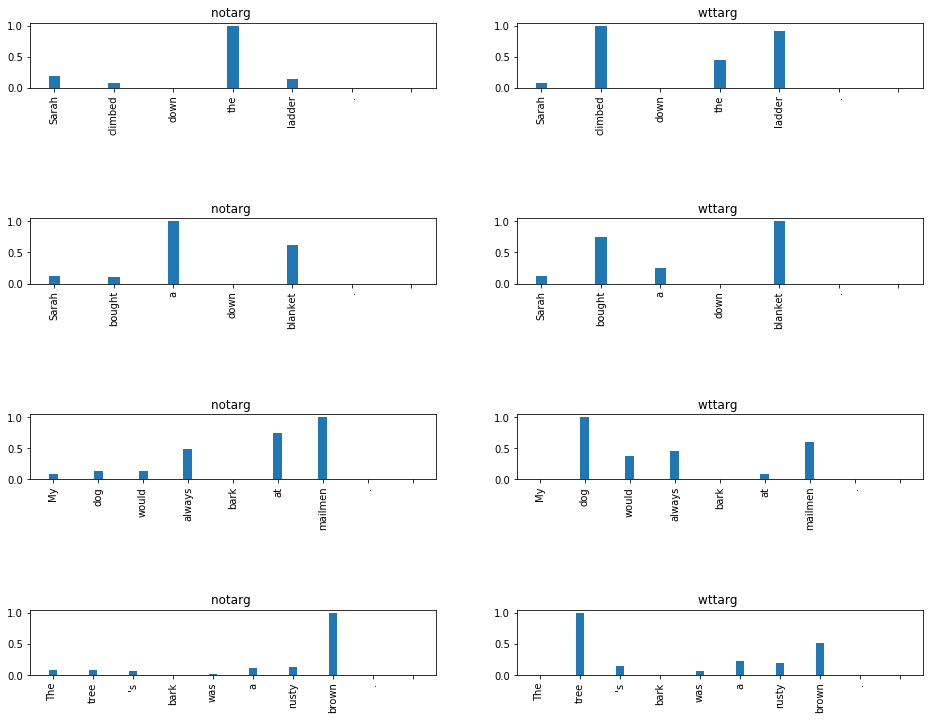

In [95]:
sent_test = sentences_homo
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = tt_notarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt2 = tt_wttarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt1 = (tt1-tt1.min())/(tt1.max()-tt1.min())    
    tt2 = (tt2-tt2.min())/(tt2.max()-tt2.min())    
    
    axes[i][0].bar(x=sent_test[1][i], height=tt1, width=0.2)
    axes[i][1].bar(x=sent_test[1][i], height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")    
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)    

## polysenym

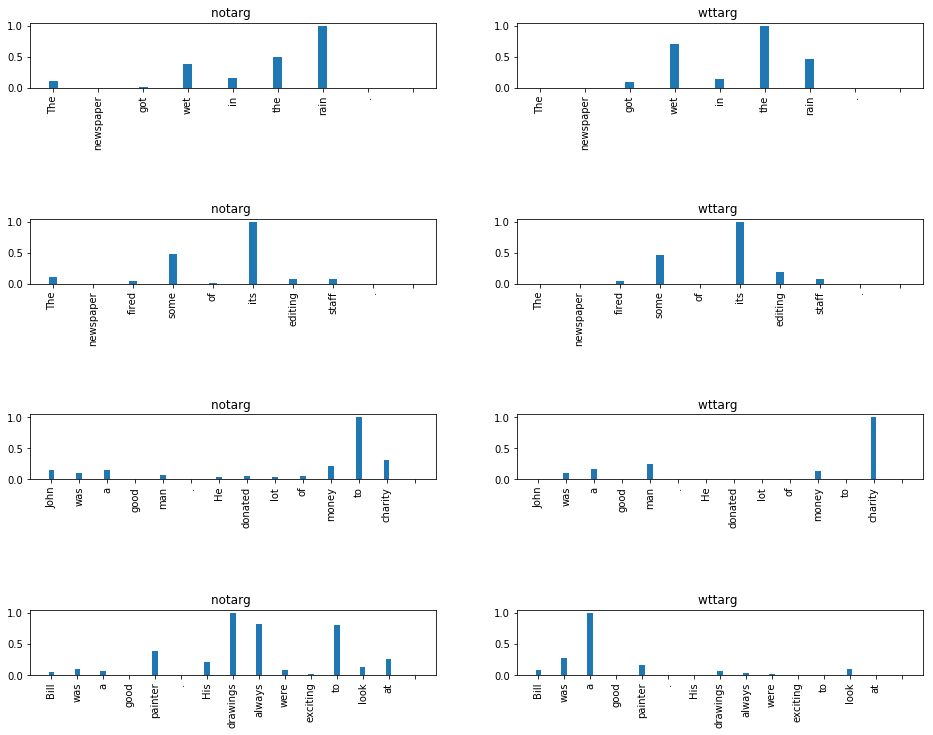

In [96]:
sent_test = sentences_poly
tt_notarg_attn = model_notarg_sfmxres.predict(sent_test)[:,0,:]
tt_wttarg_attn = model_wttarg_sfmxres.predict(sent_test)[:,0,:]

fig, axes = plt.subplots(len(tt_notarg_attn), 2, figsize=(16, len(tt_notarg_attn)*3))
fig.subplots_adjust(hspace=2)

for i in range(len(tt_wttarg_attn)):
    tt1 = tt_notarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt2 = tt_wttarg_attn[i]*(sent_test[2][i]+sent_test[3][i])
    tt1 = (tt1-tt1.min())/(tt1.max()-tt1.min())    
    tt2 = (tt2-tt2.min())/(tt2.max()-tt2.min())    
    
    axes[i][0].bar(x=sent_test[1][i], height=tt1, width=0.2)
    axes[i][1].bar(x=sent_test[1][i], height=tt2, width=0.2)
    axes[i][0].set_title("notarg ")
    axes[i][1].set_title("wttarg ")
    axes[i][0].tick_params(axis='x', rotation=90)
    axes[i][1].tick_params(axis='x', rotation=90)    